# Feb 09, 2022 (LED vs. REST; GLM)

**Motivation**: Here I concatenate data over all runs for animals.  And finally over all animals. <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
mice = Mice(256)
mice.setup_func_data('led')
nn = len(mice.node_lookup['ca2'])
df_st = mice.load_stim_times('ca2')

In [3]:
duration = 40
fwd = 350
bwd = 150

data_led = collections.defaultdict(list)
data_rest = collections.defaultdict(list)
for key, (sub, ses, run) in mice.looper.items():
    if key in mice.looper_agg:
        continue
    df = df_st.loc[df_st['key'] == key]
    stim = df['stim'].values
    on = np.where(np.diff(stim) > 0)[0] + 1
    off = np.where(np.diff(stim) < 0)[0] + 1
    if not (len(on) and len(off)):
        continue

    base = Base(mice, key=key, mode='ca2')

    selected_periods = [range(j - duration, j) for j in off]
    ids_led = []
    for r in selected_periods:
        ids_led.extend(list(r))
    ids_led = np.array(ids_led)
    
    control_periods = [range(j + fwd - duration, j + fwd) for j in off]
    ids_rest = []
    for r in control_periods:
        ids_rest.extend(list(r))
    if max(ids_rest) > base.data.shape[-1]:
        control_periods = [range(j - bwd - duration, j - bwd) for j in on]
        ids_rest = []
        for r in control_periods:
            ids_rest.extend(list(r))
    ids_rest = np.array(ids_rest)
    
    assert max(ids_rest) < base.data.shape[-1]
    assert min(ids_rest) > 0
    
    data_led[sub - 1].append(np.expand_dims(base.data[:, ids_led], 0))
    data_rest[sub - 1].append(np.expand_dims(base.data[:, ids_rest], 0))
    
data_led = {k: np.concatenate(v) for k, v in data_led.items()}
data_rest = {k: np.concatenate(v) for k, v in data_rest.items()}

In [4]:
{k: v.shape for k, v in data_led.items()}, {k: v.shape for k, v in data_rest.items()}

(
    {
        0: (9, 318, 400),
        1: (9, 318, 400),
        2: (6, 318, 400),
        3: (9, 318, 400),
        4: (9, 318, 400),
        5: (8, 318, 400),
        6: (5, 318, 400),
        7: (6, 318, 400),
        8: (6, 318, 400),
        9: (9, 318, 400)
    },
    {
        0: (9, 318, 400),
        1: (9, 318, 400),
        2: (6, 318, 400),
        3: (9, 318, 400),
        4: (9, 318, 400),
        5: (8, 318, 400),
        6: (5, 318, 400),
        7: (6, 318, 400),
        8: (6, 318, 400),
        9: (9, 318, 400)
    }
)

In [5]:
cat_led = {
    k: np.transpose(v, (1, 0, -1)).reshape(nn, -1)
    for k, v in data_led.items()
}
cat_rest = {
    k: np.transpose(v, (1, 0, -1)).reshape(nn, -1)
    for k, v in data_rest.items()
}

In [6]:
adj_led = {
    k: get_adj_mat(v, 'spearman')[0]
    for k, v in cat_led.items()
}
adj_rest = {
    k: get_adj_mat(v, 'spearman')[0]
    for k, v in cat_rest.items()
}

In [7]:
good_nodes = np.zeros((len(cat_led), nn), dtype=bool)
for i, data in cat_led.items():
    nonan = np.isnan(data).sum(-1) == 0
    good_nodes[i] = nonan

In [8]:
diff = {i: v - adj_rest[i] for i, v in adj_led.items()}
diff_abs = {i: np.abs(d) for i, d in diff.items()}
diff_norm = {
    i: np.linalg.norm(d[good_nodes[i]], axis=0)
    for i, d in diff.items()
}

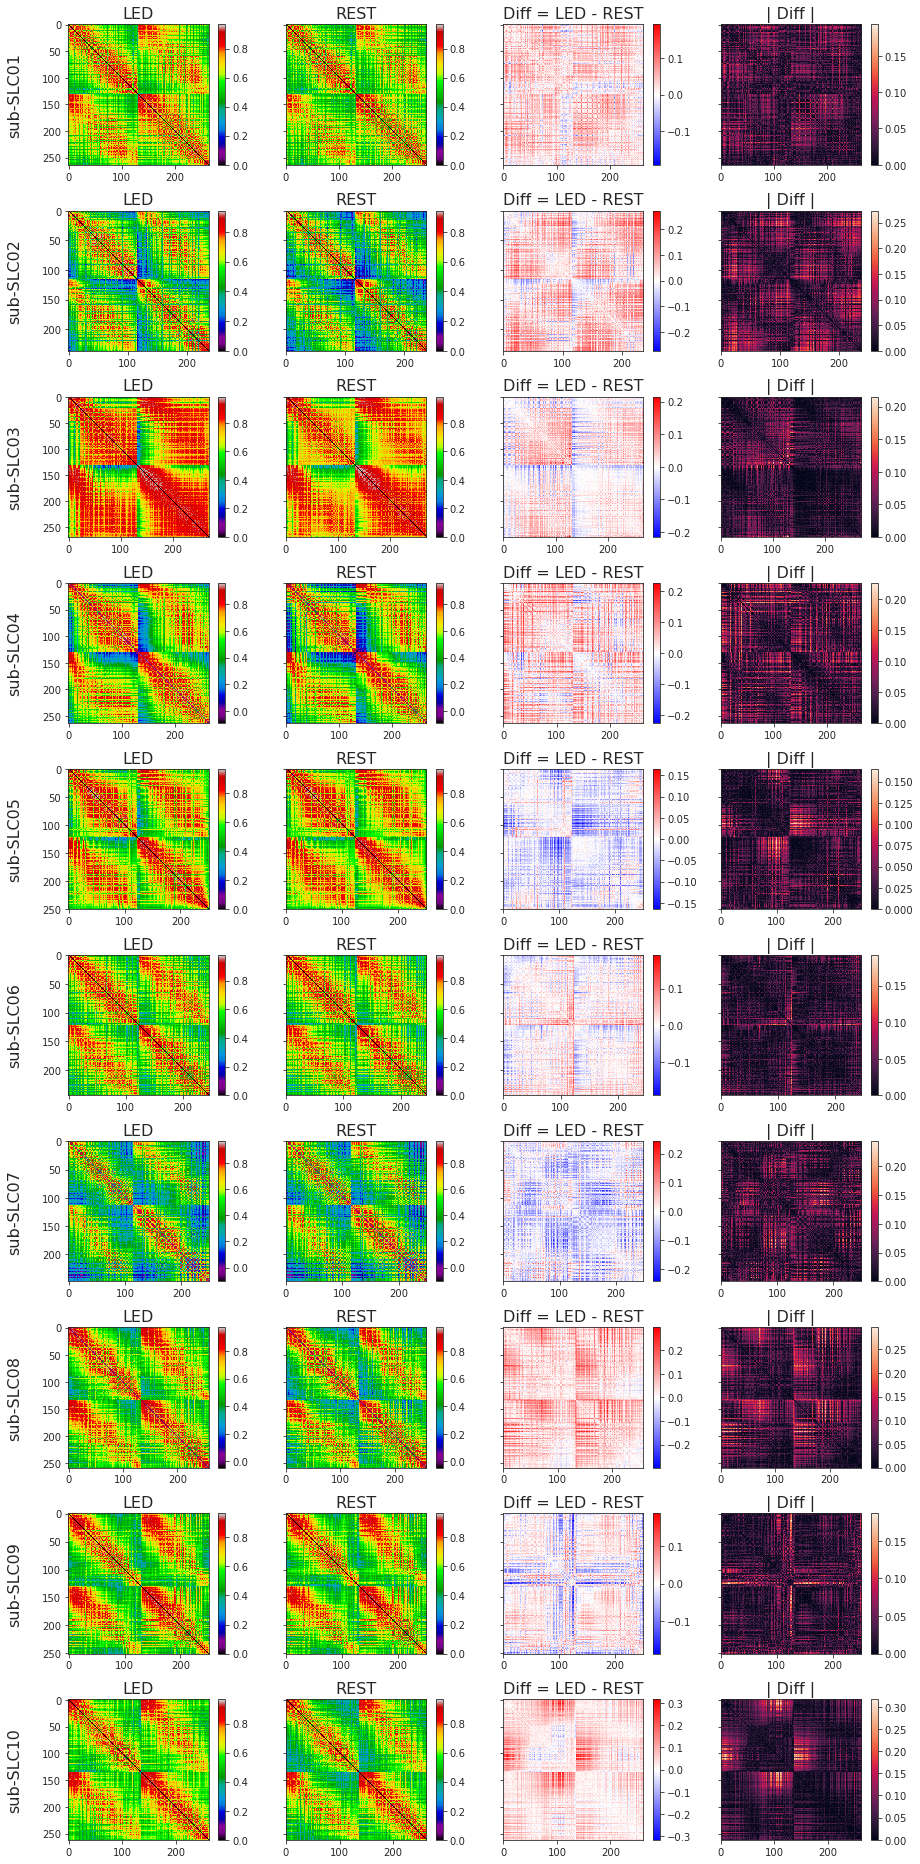

In [9]:
fig, axes = create_figure(10, 4, (13., 26), 'row', 'row')

for i in range(10):
    vmin = min(np.min(adj_led[i]), np.min(adj_rest[i]))
    vmax = min(np.max(adj_led[i]), np.max(adj_rest[i]))

    ax = axes[i, 0]
    x2plt = adj_led[i]
    x2plt = x2plt[good_nodes[i]][:, good_nodes[i]]
    im = ax.imshow(x2plt, vmin=vmin, vmax=vmax, cmap='nipy_spectral')
    plt.colorbar(im, ax=ax)
    ax.set_title('LED', fontsize=16)
    ax.set_ylabel(mice.get_key(i + 1), fontsize=16, labelpad=20)

    ax = axes[i, 1]
    x2plt = adj_rest[i]
    x2plt = x2plt[good_nodes[i]][:, good_nodes[i]]
    im = ax.imshow(x2plt, vmin=vmin, vmax=vmax, cmap='nipy_spectral')
    plt.colorbar(im, ax=ax)
    ax.set_title('REST', fontsize=16)

    ax = axes[i, 2]
    vminmax = np.nanmax(np.abs(diff[i]))
    # print(i, j, vminmax)
    # vminmax = 0.6
    x2plt = diff[i]
    x2plt = x2plt[good_nodes[i]][:, good_nodes[i]]
    im = ax.imshow(x2plt, vmin=-vminmax, vmax=vminmax, cmap='bwr')
    # im = ax.imshow(x2plt, cmap='bwr')
    plt.colorbar(im, ax=ax)
    ax.set_title('Diff = LED - REST', fontsize=16)

    ax = axes[i, 3]
    x2plt = diff_abs[i]
    x2plt = x2plt[good_nodes[i]][:, good_nodes[i]]
    im = ax.imshow(x2plt, cmap='rocket')
    plt.colorbar(im, ax=ax)
    ax.set_title('| Diff |', fontsize=16)

#fig.suptitle(f"{}", fontsize=18, y=1.01)
plt.show()

In [10]:
top, flat = base.load_top_flat()
top.shape

(1320, 1140)

In [11]:
diff_proj = np_nans((10, *top.shape))
for i in range(10):
    x = diff_norm[i]
    x[~good_nodes[i]] = np.nan
    proj = base.project_vec(x, thres=min(x), add_disjoint=False)
    diff_proj[i] = proj['top'][0]

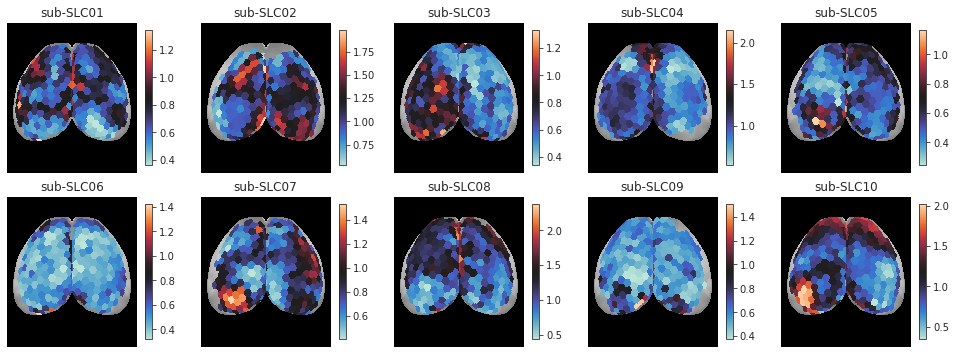

In [12]:
fig, axes = create_figure(2, 5, figsize=(13.5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(top, cmap='Greys_r')
    x2plt = diff_proj[i]
    x2plt = np.ma.masked_where(x2plt == 0, x2plt)
    im = ax.imshow(x2plt, cmap='icefire')
    plt.colorbar(im, ax=ax, shrink=0.9)
    ax.set_title(mice.get_key(i + 1))
remove_ticks(axes)

In [13]:
anim = 9

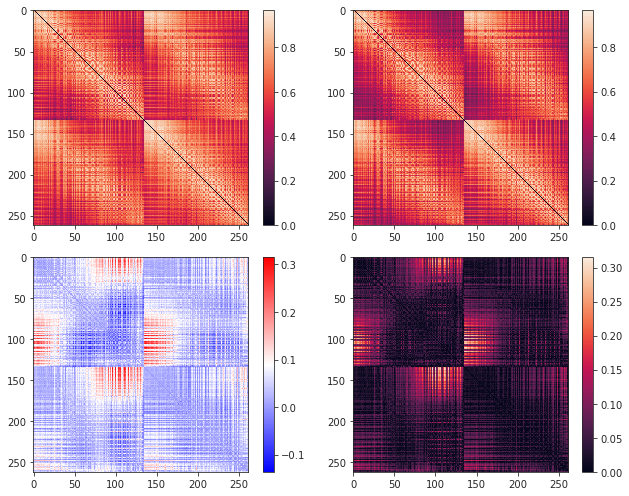

In [14]:
fig, axes = create_figure(2, 2, (9, 7))
im = axes[0, 0].imshow(adj_led[anim][good_nodes[anim]][:, good_nodes[anim]])
plt.colorbar(im, ax=axes[0, 0])
im = axes[0, 1].imshow(adj_rest[anim][good_nodes[anim]][:, good_nodes[anim]])
plt.colorbar(im, ax=axes[0, 1])
im = axes[1, 0].imshow(diff[anim][good_nodes[anim]][:, good_nodes[anim]], cmap='bwr')
plt.colorbar(im, ax=axes[1, 0])
im = axes[1, 1].imshow(diff_abs[anim][good_nodes[anim]][:, good_nodes[anim]])
plt.colorbar(im, ax=axes[1, 1])
plt.show()

In [15]:
anim = 9
d = diff[anim][good_nodes[anim]][:, good_nodes[anim]]

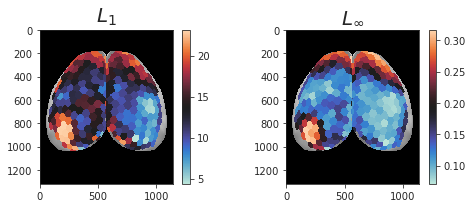

In [16]:
fig, axes = create_figure(1, 2, (7, 3))
axes[0].imshow(top, cmap='Greys_r')
axes[1].imshow(top, cmap='Greys_r')

d_norm = np.zeros(nn)
d_norm[good_nodes[anim]] = np.linalg.norm(d, ord=1, axis=0)
proj = base.project_vec(d_norm, thres=min(d_norm), add_disjoint=False)

x2plt = proj['top'][0]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)
im = axes[0].imshow(x2plt ,cmap='icefire')
plt.colorbar(im, ax=axes[0])
axes[0].set_title(r"$L_1$", fontsize=20, y=1.01)

d_norm = np.zeros(nn)
d_norm[good_nodes[anim]] = np.max(np.abs(d), axis=0)
proj = base.project_vec(d_norm, thres=min(d_norm), add_disjoint=False)

x2plt = proj['top'][0]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)
im = axes[1].imshow(x2plt ,cmap='icefire')
plt.colorbar(im, ax=axes[1])
axes[1].set_title(r"$L_{\infty}$", fontsize=20, y=1.01)
plt.show()

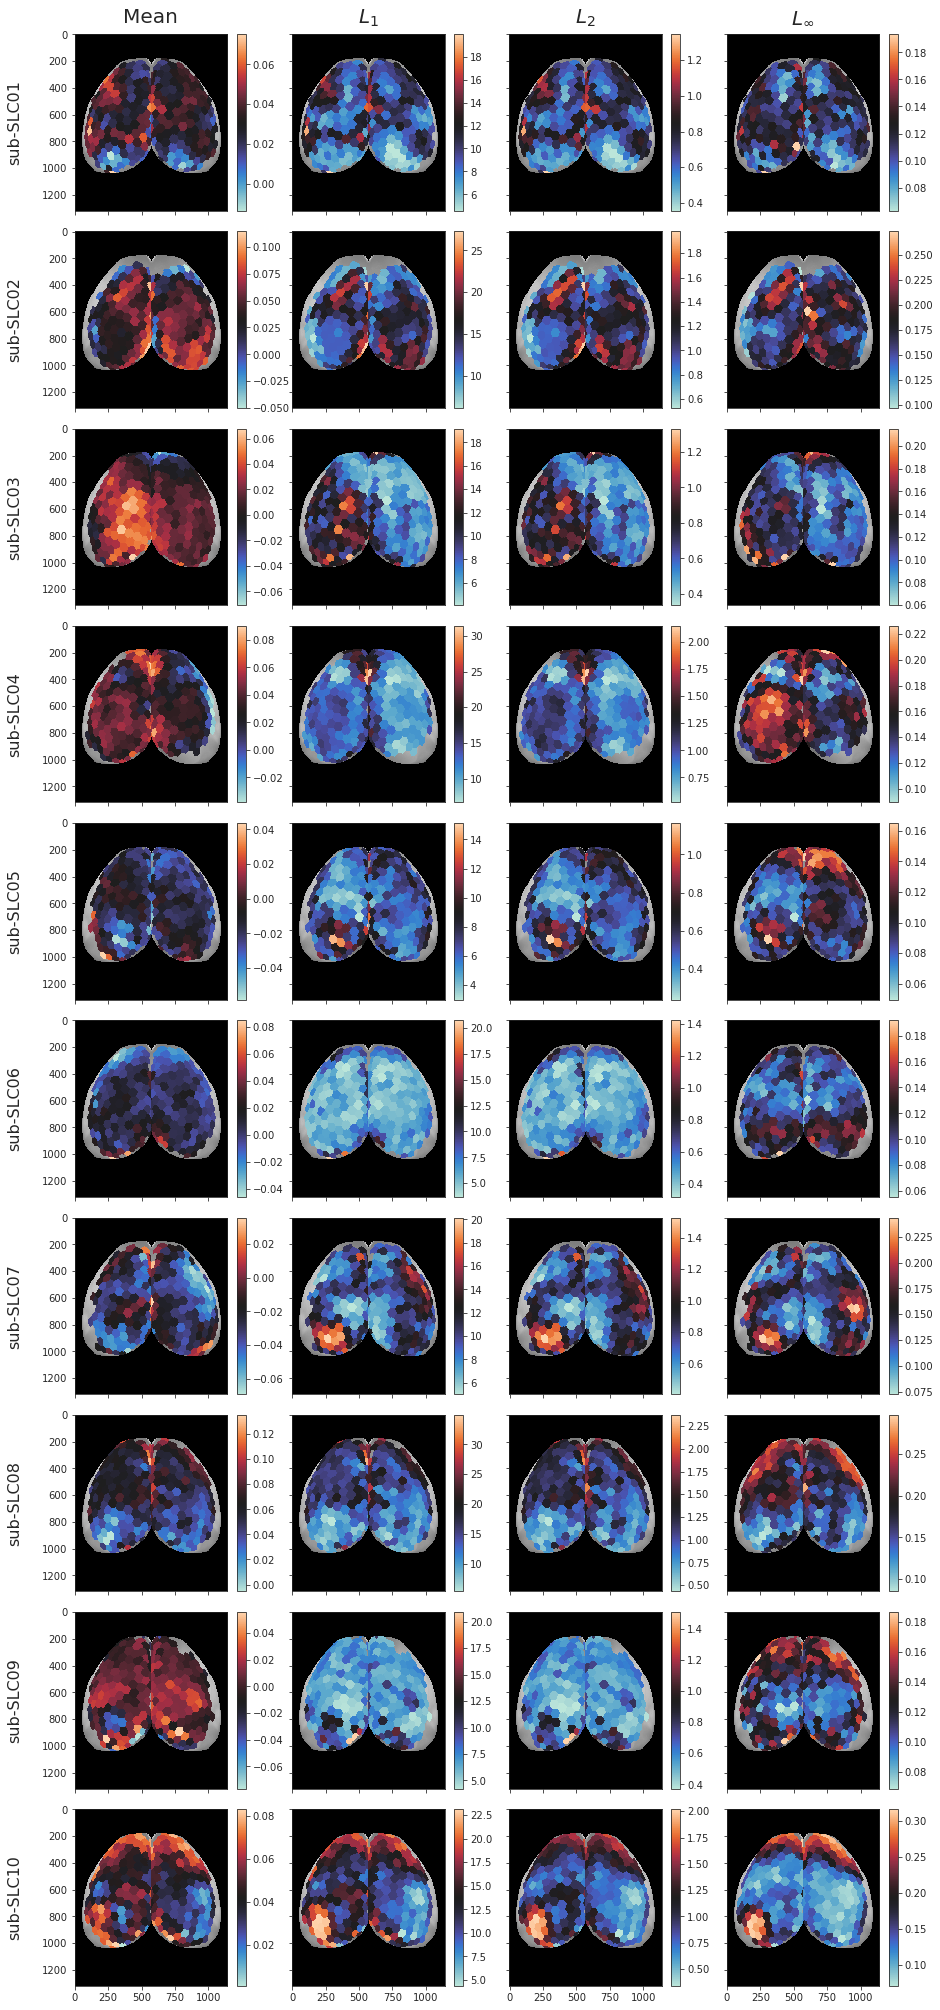

In [17]:
fig, axes = create_figure(10, 4, (13, 28), 'all', 'all')
for ax in axes.flat:
    ax.imshow(top, cmap='Greys_r')

axes[0, 0].set_title('Mean', fontsize=20, y=1.03)
axes[0, 1].set_title(r"$L_1$", fontsize=20, y=1.03)
axes[0, 2].set_title(r"$L_2$", fontsize=20, y=1.03)
axes[0, 3].set_title(r"$L_{\infty}$", fontsize=20, y=1.03)

for anim in range(10):
    axes[anim, 0].set_ylabel(mice.get_key(anim + 1), fontsize=16, labelpad=20)
    
    d = diff[anim][good_nodes[anim]][:, good_nodes[anim]]

    d_norm = np.zeros(nn)
    d_norm[good_nodes[anim]] = d.mean(0)
    proj = base.project_vec(d_norm, thres=min(d_norm), add_disjoint=False)

    x2plt = proj['top'][0]
    x2plt = np.ma.masked_where(x2plt == 0, x2plt)
    im = axes[anim, 0].imshow(x2plt ,cmap='icefire')
    plt.colorbar(im, ax=axes[anim, 0])

    d_norm = np.zeros(nn)
    d_norm[good_nodes[anim]] = np.linalg.norm(d, ord=1, axis=0)
    proj = base.project_vec(d_norm, thres=min(d_norm), add_disjoint=False)

    x2plt = proj['top'][0]
    x2plt = np.ma.masked_where(x2plt == 0, x2plt)
    im = axes[anim, 1].imshow(x2plt ,cmap='icefire')
    plt.colorbar(im, ax=axes[anim, 1])

    d_norm = np.zeros(nn)
    d_norm[good_nodes[anim]] = np.linalg.norm(d, ord=2, axis=0)
    proj = base.project_vec(d_norm, thres=min(d_norm), add_disjoint=False)

    x2plt = proj['top'][0]
    x2plt = np.ma.masked_where(x2plt == 0, x2plt)
    im = axes[anim, 2].imshow(x2plt ,cmap='icefire')
    plt.colorbar(im, ax=axes[anim, 2])

    d_norm = np.zeros(nn)
    d_norm[good_nodes[anim]] = np.max(np.abs(d), axis=0)
    proj = base.project_vec(d_norm, thres=min(d_norm), add_disjoint=False)

    x2plt = proj['top'][0]
    x2plt = np.ma.masked_where(x2plt == 0, x2plt)
    im = axes[anim, 3].imshow(x2plt ,cmap='icefire')
    plt.colorbar(im, ax=axes[anim, 3])

plt.show()

In [18]:
led = np.concatenate([e for e in cat_led.values()], axis=-1)
rest = np.concatenate([e for e in cat_rest.values()], axis=-1)
good_all = np.logical_and(np.isnan(led).sum(1) == 0, np.isnan(rest).sum(1) == 0)
led = led[good_all]
rest = rest[good_all]

led.shape, rest.shape

((189, 30400), (189, 30400))

In [19]:
al, _ = get_adj_mat(led, 'spearman')
ar, _ = get_adj_mat(rest, 'spearman')
d = al - ar
da = np.abs(ar - al)

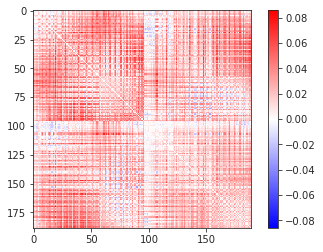

In [20]:
vminmax = np.max(np.abs(d))
plt.imshow(d, vmin=-vminmax, vmax=vminmax, cmap='bwr')
plt.colorbar();

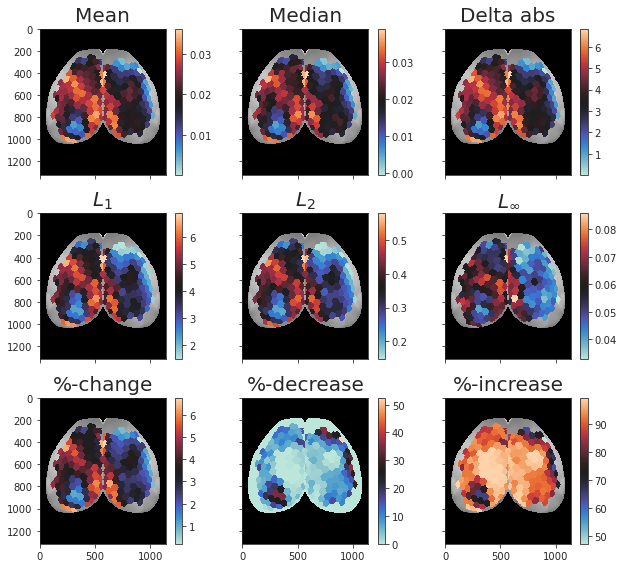

In [21]:
fig, axes = create_figure(3, 3, (9, 8), 'all', 'all')
for ax in axes.flat:
    ax.imshow(top, cmap='Greys_r')

d_norm = np.zeros(nn)
d_norm[good_all] = np.mean(d, 0)
proj = base.project_vec(d_norm, thres=min(d_norm), add_disjoint=False)
x2plt = proj['top'][0]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)
ax = axes[0, 0]
im = ax.imshow(x2plt ,cmap='icefire')
plt.colorbar(im, ax=ax)
ax.set_title('Mean', fontsize=20, y=1.01)

d_norm = np.zeros(nn)
d_norm[good_all] = np.median(d, 0)
proj = base.project_vec(d_norm, thres=min(d_norm), add_disjoint=False)
x2plt = proj['top'][0]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)
ax = axes[0, 1]
im = ax.imshow(x2plt ,cmap='icefire')
plt.colorbar(im, ax=ax)
ax.set_title('Median', fontsize=20, y=1.01)

d_norm = np.zeros(nn)
d_norm[good_all] = np.abs(al).sum(0) - np.abs(ar).sum(0)
proj = base.project_vec(d_norm, thres=min(d_norm), add_disjoint=False)
x2plt = proj['top'][0]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)
ax = axes[0, 2]
im = ax.imshow(x2plt ,cmap='icefire')
plt.colorbar(im, ax=ax)
ax.set_title('Delta abs', fontsize=20, y=1.01)


d_norm = np.zeros(nn)
d_norm[good_all] = np.linalg.norm(d, ord=1, axis=0)
proj = base.project_vec(d_norm, thres=min(d_norm), add_disjoint=False)
x2plt = proj['top'][0]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)
ax = axes[1, 0]
im = ax.imshow(x2plt ,cmap='icefire')
plt.colorbar(im, ax=ax)
ax.set_title(r"$L_1$", fontsize=20, y=1.01)

d_norm = np.zeros(nn)
d_norm[good_all] = np.linalg.norm(d, ord=2, axis=0)
proj = base.project_vec(d_norm, thres=min(d_norm), add_disjoint=False)
x2plt = proj['top'][0]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)
ax = axes[1, 1]
im = ax.imshow(x2plt ,cmap='icefire')
plt.colorbar(im, ax=ax)
ax.set_title(r"$L_2$", fontsize=20, y=1.01)

d_norm = np.zeros(nn)
d_norm[good_all] = np.max(np.abs(d), axis=0)
proj = base.project_vec(d_norm, thres=min(d_norm), add_disjoint=False)
x2plt = proj['top'][0]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)
ax = axes[1, 2]
im = ax.imshow(x2plt ,cmap='icefire')
plt.colorbar(im, ax=ax)
ax.set_title(r"$L_{\infty}$", fontsize=20, y=1.01)


d_norm = np.zeros(nn)
d_norm[good_all] = bn.nanmean((al - ar) / ar, 0) * 100
proj = base.project_vec(d_norm, thres=min(d_norm), add_disjoint=False)
x2plt = proj['top'][0]
# vminmax = np.max(np.abs(proj['top'][0]))
x2plt = np.ma.masked_where(x2plt == 0, x2plt)
ax = axes[2, 0]
im = ax.imshow(x2plt, cmap='icefire')
plt.colorbar(im, ax=ax)
ax.set_title('%-change', fontsize=20, y=1.01)

d_norm = np.zeros(nn)
d_norm[good_all] = (d < 0).mean(0) * 100
proj = base.project_vec(d_norm, thres=min(d_norm), add_disjoint=False)
x2plt = proj['top'][0]
vminmax = np.max(np.abs(proj['top'][0]))
x2plt = np.ma.masked_where(top == 0, x2plt)
ax = axes[2, 1]
im = ax.imshow(x2plt, cmap='icefire')
plt.colorbar(im, ax=ax)
ax.set_title('%-decrease', fontsize=20, y=1.01)

d_norm = np.zeros(nn)
d_norm[good_all] = (d > 0).mean(0) * 100
proj = base.project_vec(d_norm, thres=min(d_norm), add_disjoint=False)
x2plt = proj['top'][0]
vminmax = np.max(np.abs(proj['top'][0]))
x2plt = np.ma.masked_where(x2plt == 0, x2plt)
ax = axes[2, 2]
im = ax.imshow(x2plt, cmap='icefire')
plt.colorbar(im, ax=ax)
ax.set_title('%-increase', fontsize=20, y=1.01)

plt.show()

## GLM

In [22]:
from sklearn import linear_model
ner = Normalizer()

In [23]:
data_all = np.concatenate([led, rest], -1)
y = [1] * led.shape[-1] + [0] * led.shape[-1]
y = np.array(y)

data_all.shape, y.shape

((189, 60800), (60800,))

In [24]:
glm = linear_model.PoissonRegressor(
    alpha=10000,
    max_iter=int(1e5),
).fit(data_all.T, y)
logreg = linear_model.LogisticRegression(
    C=0.0001,
    penalty='l2',
    solver='lbfgs',
).fit(data_all.T, y)

c_glm = np.zeros(nn)
c_glm[good_all] = glm.coef_
c_glm = ner.fit_transform(c_glm.reshape(1, -1))
c_glm = c_glm.ravel()
if max(c_glm, key=abs) < 0:
    c_glm *= -1

c_logreg = np.zeros(nn)
c_logreg[good_all] = logreg.coef_.ravel()
c_logreg = ner.fit_transform(c_logreg.reshape(1, -1))
c_logreg = c_logreg.ravel()
if max(c_logreg, key=abs) < 0:
    c_logreg *= -1

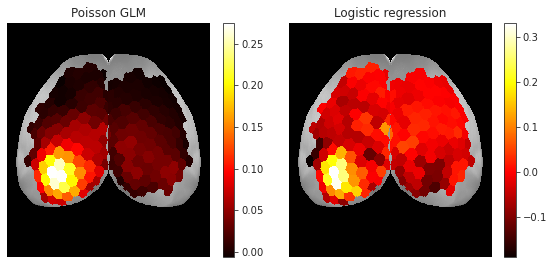

In [25]:
fig, axes = create_figure(1, 2, (8, 3.7))

proj = base.project_vec(c_glm, thres=min(c_glm), add_disjoint=False)
x2plt = proj['top'][0]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)
axes[0].imshow(top, cmap='Greys_r')
im = axes[0].imshow(x2plt, cmap='hot')
plt.colorbar(im, ax=axes[0])
axes[0].set_title('Poisson GLM')

proj = base.project_vec(c_logreg, thres=min(c_logreg), add_disjoint=False)
x2plt = proj['top'][0]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)
axes[1].imshow(top, cmap='Greys_r')
im = axes[1].imshow(x2plt, cmap='hot')
plt.colorbar(im, ax=axes[1])
axes[1].set_title('Logistic regression')

remove_ticks(axes)